# Harmonizing Bytes and Beats: Enhancing Music Discovery through Advanced Genre Classification

## IMPORTS

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [39]:
data = pd.read_csv('updated_dataset.csv')

In [40]:
data.head()

,track_id,name,artist,genre,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms,album_cover_url
0,6hTcuIQa0sxrrByu9wTD7s,Born to Run,Bruce Springsteen,rock,1975-08-25,0.270,0.944,4,-4.199,1,0.0975,0.00501,0.000021,0.1160,0.606,146.347,4,269920,https://i.scdn.co/image/ab67616d0000b273503143...
1,2qJkesdHu9sMMVFgkRkqhQ,Angel,Theory of a Deadman,rock,2014-07-08,0.443,0.844,11,-5.414,0,0.0425,0.00251,0.000000,0.0850,0.452,76.001,4,202213,https://i.scdn.co/image/ab67616d0000b273fe4003...
2,3fkPMWQ6cBNBLuFcPyMS8s,Burnin' for You,Blue Öyster Cult,rock,1981-10-23,0.532,0.728,9,-9.079,0,0.0352,0.10600,0.010800,0.0849,0.690,134.303,4,271000,https://i.scdn.co/image/ab67616d0000b2736895da...
3,2URDbWGmPz3vhagl25p8OC,Tranquility Base Hotel & Casino,Arctic Monkeys,rock,2018-05-10,0.584,0.835,9,-4.326,0,0.0297,0.04110,0.014700,0.1990,0.781,142.200,4,212093,https://i.scdn.co/image/ab67616d0000b2738895ff...
4,48UPSzbZjgc449aqz8bxox,Californication,Red Hot Chili Peppers,rock,1999-06-08,0.592,0.767,9,-2.788,0,0.0270,0.00210,0.001650,0.1270,0.328,96.483,4,329733,https://i.scdn.co/image/ab67616d0000b27394d08a...


In [41]:
data.shape

(6976, 19)

## Exploratory Data Analysis

In [42]:
print("Basic information about the dataset:")
d=data.info()

Basic information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6976 entries, 0 to 6975
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          6976 non-null   object 
 1   name              6971 non-null   object 
 2   artist            6971 non-null   object 
 3   genre             6976 non-null   object 
 4   release_date      6976 non-null   object 
 5   danceability      6976 non-null   float64
 6   energy            6976 non-null   float64
 7   key               6976 non-null   int64  
 8   loudness          6976 non-null   float64
 9   mode              6976 non-null   int64  
 10  speechiness       6976 non-null   float64
 11  acousticness      6976 non-null   float64
 12  instrumentalness  6976 non-null   float64
 13  liveness          6976 non-null   float64
 14  valence           6976 non-null   float64
 15  tempo             6976 non-null   float64
 16  time_

In [43]:
print("\nChecking for missing values:")
print(data.isnull().sum())


Checking for missing values:
track_id            0
name                5
artist              5
genre               0
release_date        0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
duration_ms         0
album_cover_url     8
dtype: int64


In [44]:
genre_counts = data.groupby('genre').size()
print(genre_counts)

genre
blues         829
classical     517
edm            89
electronic    838
folk          817
hip-hop       821
indie         787
jazz          563
metal          94
pop           802
rock          819
dtype: int64


### The above missing values are in name of the song, artist, and album_cover_url which are not needed in our analysis further. Hence, there is no need to handle them.

In [45]:
print("\nSummary statistics for numerical features:")
print(data.describe())


Summary statistics for numerical features:
       danceability       energy          key     loudness         mode  \
count   6976.000000  6976.000000  6976.000000  6976.000000  6976.000000   
mean       0.555648     0.584291     5.200115    -9.164872     0.632884   
std        0.179621     0.260664     3.571505     5.723069     0.482053   
min        0.000000     0.000049     0.000000   -43.804000     0.000000   
25%        0.440000     0.406000     2.000000   -11.211750     0.000000   
50%        0.561000     0.622000     5.000000    -7.532500     1.000000   
75%        0.685000     0.798000     8.000000    -5.273750     1.000000   
max        0.976000     0.998000    11.000000     1.342000     1.000000   

       speechiness  acousticness  instrumentalness     liveness      valence  \
count  6976.000000   6976.000000       6976.000000  6976.000000  6976.000000   
mean      0.083112      0.332591          0.172990     0.187967     0.452430   
std       0.086869      0.355534        

In [46]:
print("\nDistribution of genres:\n")
genre_counts = data.groupby('genre').size()
print(genre_counts)


Distribution of genres:

genre
blues         829
classical     517
edm            89
electronic    838
folk          817
hip-hop       821
indie         787
jazz          563
metal          94
pop           802
rock          819
dtype: int64


### We can see that metal has very less inputs in the dataset and its better to drop them 

In [47]:
genres_to_remove = ['metal', 'edm','indie','pop','jazz','blues']
data = data[~data['genre'].isin(genres_to_remove)]

In [48]:
print("\nDistribution of genres:\n")
genre_counts = data.groupby('genre').size()
print(genre_counts)


Distribution of genres:

genre
classical     517
electronic    838
folk          817
hip-hop       821
rock          819
dtype: int64


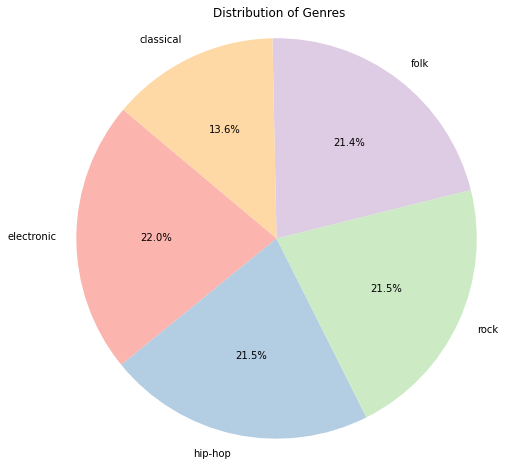

In [49]:
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and it has a 'genre' column
genre_counts = data['genre'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title('Distribution of Genres')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.show()


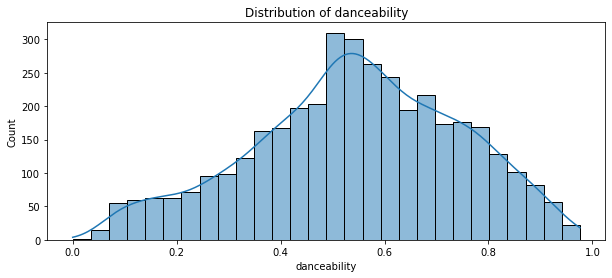

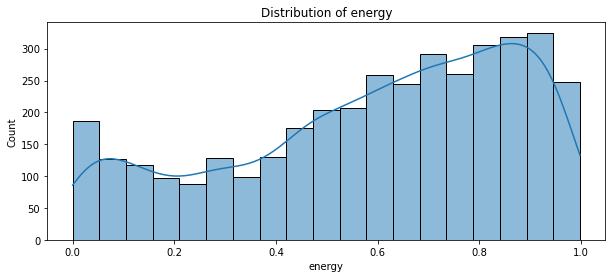

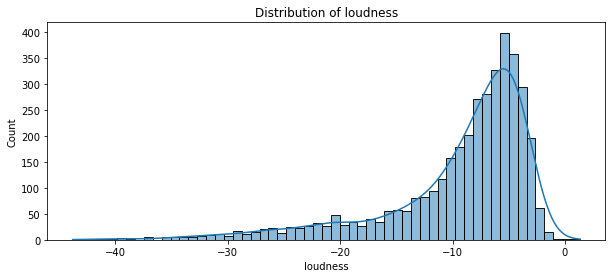

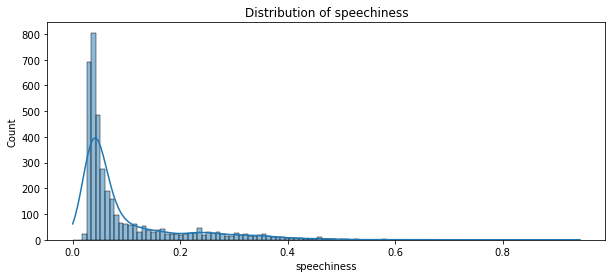

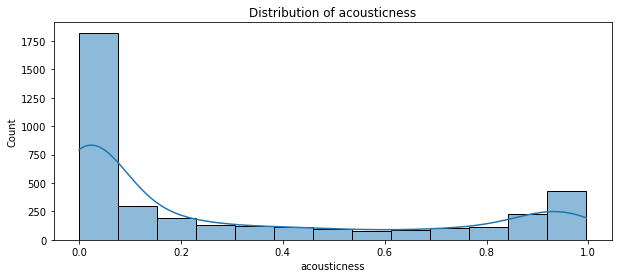

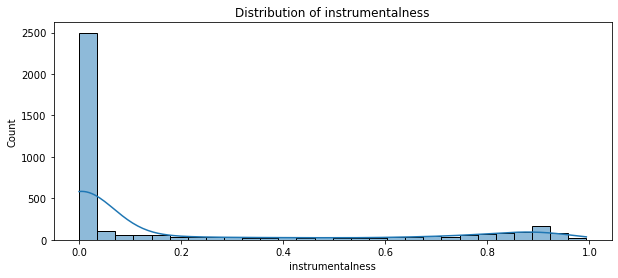

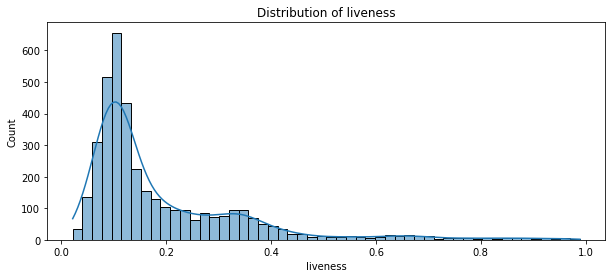

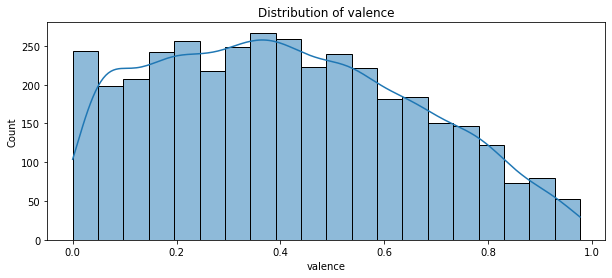

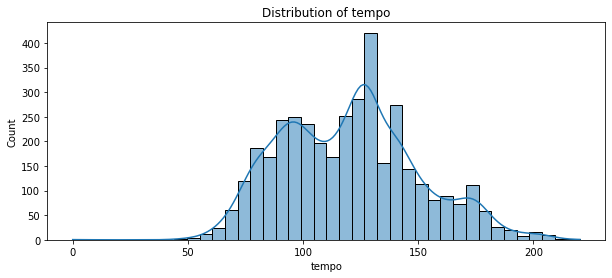

In [50]:
numerical_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
for feature in numerical_features:
    plt.figure(figsize=(10, 4))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

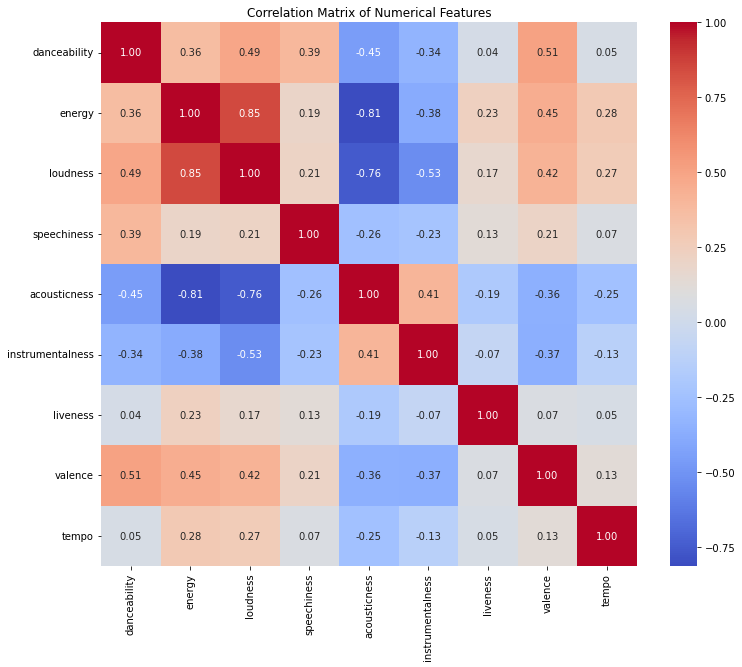

In [51]:
plt.figure(figsize=(12, 10))
sns.heatmap(data[numerical_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [52]:
data = data.drop(['loudness'], axis=1)

In [53]:
from sklearn.preprocessing import StandardScaler

# Selecting numerical features for standardization
numerical_features = ['danceability', 'energy', 'speechiness', 
                      'acousticness', 'instrumentalness', 'liveness', 
                      'valence', 'tempo', 'duration_ms']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical features
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Check the transformed data
print(data[numerical_features].head())

   danceability    energy  speechiness  acousticness  instrumentalness  \
0     -1.366980  1.249156     0.028000     -0.825370         -0.601719   
1     -0.502748  0.891113    -0.525186     -0.832300         -0.601782   
2     -0.058143  0.475784    -0.598608     -0.545444         -0.568868   
3      0.201626  0.858890    -0.653927     -0.725335         -0.556982   
4      0.241590  0.615421    -0.681083     -0.833436         -0.596753   

   liveness   valence     tempo  duration_ms  
0 -0.473417  0.789108  0.891940     0.019891  
1 -0.673069  0.161948 -1.490163    -0.447880  
2 -0.673713  1.131195  0.484098     0.027352  
3  0.061134  1.501789  0.751511    -0.379621  
4 -0.402573 -0.343037 -0.796588     0.433124  


In [54]:
from joblib import dump

# Assuming your scaler is named "scaler" and has been fitted to your training data
dump(scaler, 'scaler2.joblib')

['scaler2.joblib']

In [55]:
data.shape

(3812, 18)

## CLASSIFICATION

In [56]:
X = data.drop(['genre', 'track_id', 'name', 'artist', 'release_date', 'album_cover_url'], axis=1)
y = data['genre']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [57]:
X

,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms
0,-1.366980,1.249156,4,1,0.028000,-0.825370,-0.601719,-0.473417,0.789108,0.891940,4,0.019891
1,-0.502748,0.891113,11,0,-0.525186,-0.832300,-0.601782,-0.673069,0.161948,-1.490163,4,-0.447880
2,-0.058143,0.475784,9,0,-0.598608,-0.545444,-0.568868,-0.673713,1.131195,0.484098,4,0.027352
3,0.201626,0.858890,9,0,-0.653927,-0.725335,-0.556982,0.061134,1.501789,0.751511,4,-0.379621
4,0.241590,0.615421,9,0,-0.681083,-0.833436,-0.596753,-0.402573,-0.343037,-0.796588,4,0.433124
...,...,...,...,...,...,...,...,...,...,...,...,...
6947,-0.717557,-1.813182,10,1,-0.622747,1.685873,-0.601703,-0.524940,-0.514081,-0.441572,1,-0.208188
6948,0.341502,-1.142568,7,1,-0.592574,1.649839,2.031342,-0.662120,-0.839878,-0.724562,4,0.615701
6949,-0.537717,-0.798847,9,1,-0.654933,1.156455,-0.463421,-0.557142,0.581412,1.488363,4,-0.357969
6959,-0.193023,-0.097084,6,1,-0.678066,0.973514,1.818010,-0.647951,-1.361154,-1.014698,4,-0.547089


In [58]:
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

In [59]:
rf = RandomForestClassifier(random_state=42)

In [60]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [20, 25, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'criterion': ['gini', 'entropy']
}

# Setup the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='accuracy', verbose=2)

In [24]:
grid_search.fit(X, y_encoded)

Fitting 6 folds for each of 72 candidates, totalling 432 fits
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.9s
[C

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [20, 25, 30], 'min_samples_leaf': [2, 4],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [26]:
# Best model's parameters 
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best Score: 0.7932827382426253


In [27]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=45)

# Initializing the Random Forest classifier with the best parameters
rf_best = RandomForestClassifier(max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=45,criterion='gini')

# Fitting the model on the training data
rf_best.fit(X_train, y_train)

# Making predictions on the test set
y_pred = rf_best.predict(X_test)

In [28]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 0.82


In [29]:
from sklearn.metrics import classification_report

# Generate the classification report for the test set predictions
report = classification_report(y_test, y_pred, target_names=le.classes_)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

   classical       0.94      0.94      0.94       115
  electronic       0.83      0.75      0.79       157
        folk       0.74      0.79      0.76       163
     hip-hop       0.87      0.95      0.90       149
        rock       0.77      0.73      0.75       179

    accuracy                           0.82       763
   macro avg       0.83      0.83      0.83       763
weighted avg       0.82      0.82      0.82       763



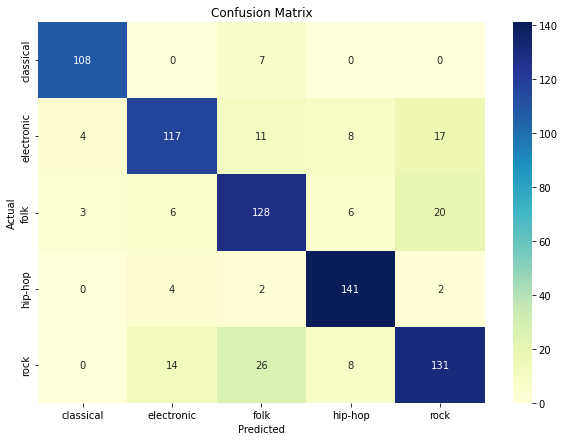

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dataframe for a nicer display
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

# Plot the heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt='g', cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### FEATURE SELECTION

In [61]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
import xgboost as xgb

In [62]:
n_splits = 6
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize the array to store feature importances
feature_importances = np.zeros(X.shape[1])

In [63]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Train the model
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    model.fit(X_train, y_train)
    
    # Update feature importances
    feature_importances += model.feature_importances_


In [64]:
feature_importances /= n_splits


In [65]:
print("Feature Importances:")
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance}")

Feature Importances:
danceability: 0.14872782429059347
energy: 0.11550392458836238
key: 0.014826715923845768
mode: 0.0066554620473956065
speechiness: 0.12503345062335333
acousticness: 0.13516468306382498
instrumentalness: 0.13920451949040094
liveness: 0.06258029118180275
valence: 0.09393588826060295
tempo: 0.0776621550321579
time_signature: 0.003930862381821498
duration_ms: 0.07677422588070233


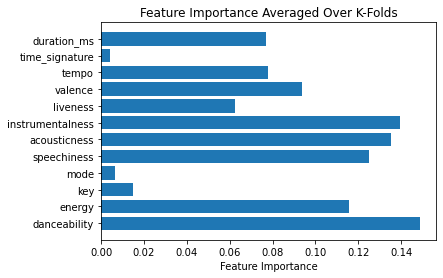

In [66]:
import matplotlib.pyplot as plt

plt.barh(X.columns, feature_importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance Averaged Over K-Folds")
plt.show()

In [71]:
X_updated = X.drop(['time_signature'], axis=1)

In [31]:
grid_search.fit(X_updated, y_encoded)

Fitting 6 folds for each of 72 candidates, totalling 432 fits
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.0s
[C

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [20, 25, 30], 'min_samples_leaf': [2, 4],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [32]:
# Best model's parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Best Score: 0.7898739662259199


In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_updated, y_encoded, test_size=0.2, random_state=45)

# Initializing the Random Forest classifier with the best parameters
rf_best = RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=100, random_state=45,criterion='entropy')

# Fitting the model on the training data
rf_best.fit(X_train, y_train)

# Making predictions on the test set
y_pred = rf_best.predict(X_test)

In [73]:
from sklearn.metrics import classification_report

# Generate the classification report for the test set predictions
report = classification_report(y_test, y_pred, target_names=le.classes_)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

   classical       0.93      0.94      0.94       115
  electronic       0.81      0.74      0.77       157
        folk       0.74      0.77      0.76       163
     hip-hop       0.86      0.95      0.90       149
        rock       0.77      0.73      0.75       179

    accuracy                           0.82       763
   macro avg       0.82      0.83      0.82       763
weighted avg       0.81      0.82      0.81       763



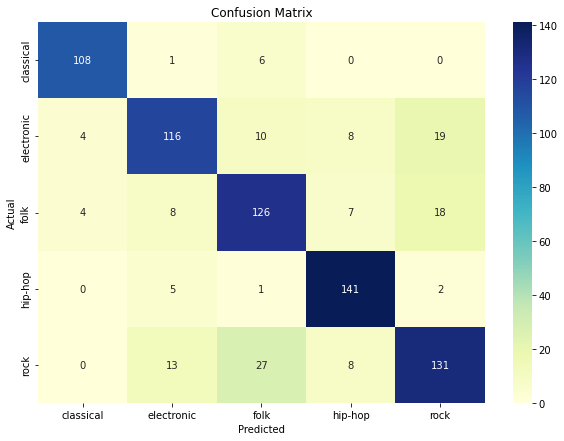

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dataframe for a nicer display
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

# Plot the heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt='g', cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## SAVING THE MODEL

In [275]:
from tensorflow.keras.models import load_model

2024-04-09 04:36:44.829637: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 04:36:44.879801: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 04:36:46.595885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [278]:
from joblib import dump, load

# Saving the model to disk
dump(rf_best, 'rf_best_model.joblib')

['rf_best_model.joblib']